# TarDiff — génération ciblée par influence (toy 2D)

Ce notebook implémente une version minimale mais complète de **TarDiff** (Target-Oriented Diffusion Guidance) sur un jeu de données gaussien 2D, avec évaluation de la fidélité distributionnelle **et** de l’utilité downstream.

## 0. Résumé exécutif & Plan de l'étude

Ce notebook propose une analyse scientifique rigoureuse de **TarDiff** en deux temps :

### Partie 1 : Validation en environnement contrôlé (Balanced)
Nous commençons par un jeu de données parfaitement équilibré (50/50).
- **Objectif** : Valider la mécanique de guidage indépendamment du déséquilibre.
- **Analyses** : 
    - Impact de la force de guidage $w$ sur la trajectoire des points (champs de vecteurs).
    - Trade-off Utilité vs Diversité.

### Partie 2 : Le challenge réel (Imbalanced 90/10)
Nous passons à un scénario déséquilibré typique (Rare Events).
- **Objectif** : Utiliser TarDiff pour forcer la génération de la classe minoritaire utile.
- **Étude d'ablation (Guidance Set)** : Sur quelles données calculer l'influence $G$ ?
    1.  Tout le set de validation ?
    2.  Uniquement la classe majoritaire ?
    3.  Uniquement la classe minoritaire ?
- **Hypothèse** : Calculer l'influence sur la classe minoritaire (même petite) fournit les gradients les plus informatifs pour guider la génération vers les zones d'intérêt.

## 1. Contexte et objectif

- **Contexte** : la génération de séries temporelles EHR vise souvent la **fidélité distributionnelle**. Cela ne garantit pas l’amélioration d’une tâche cible, surtout en cas d’**imbalance** ou de **patterns rares**.
- **Objectif TarDiff** : produire des samples qui **améliorent explicitement** une métrique downstream en intégrant un **signal d’influence** dans le processus de diffusion.
- **Dans ce notebook** : on illustre TarDiff sur un toy gaussien 2D conditionné par une étiquette binaire, puis on discute l’extension vers des séries temporelles réelles.

## 2. Rappels et notations minimales

- Données : $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$ avec $x_i \in \mathbb{R}^2$, $y_i \in \{0,1\}$.
- Distribution réelle : $p_{\text{data}}(x, y)$; distribution synthétique : $p_\theta(x, y)$.
- Diffusion conditionnelle (DDPM) : on apprend un modèle $\epsilon_\theta(x_t, t, y)$ et on sample en inversant le processus de bruitage.
- **Dans ce notebook** :
  - diffusion 2D conditionnelle sur $y$,
  - un classifieur simple $f_\phi$ pour la tâche downstream,
  - un guidance set $\mathcal{D}_{\text{guide}}$ (souvent la validation).

## 3. Méthode TarDiff (lecture papier)

L'idée centrale de TarDiff est de transformer un problème de génération (imiter la distribution des données) en un problème de génération orientée tâche : on guide la diffusion pour produire des exemples synthétiques qui, s'ils étaient ajoutés au train, amélioreraient la performance d'un modèle downstream sur des données i.i.d. non vues.

### 3.1 Influence : mesurer l'utilité d'un point synthétique pour une tâche

On fixe une tâche downstream $T$ avec une loss $\ell_T(\cdot;\phi)$ et un modèle $f_\phi$. Sur le dataset d'entraînement

$$
\mathcal{D}_{\text{train}}=\{(x_i,y_i)\}_{i=1}^n,
$$

on définit les paramètres optimaux :

$$
\phi^*=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}}\ell_T(x_i,y_i;\phi).
$$

On considère ensuite un échantillon synthétique candidat $\hat{z}=(x,y)$ que l'on ajouterait au train. Le nouvel optimum devient :

$$
\phi^{\hat{z}}=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}\cup\{\hat{z}\}}\ell_T(x_i,y_i;\phi).
$$

Pour une donnée de test $(x',y')$, on regarde le changement de loss induit par l'ajout de $\hat{z}$ :

$$
H(x,y,x',y')=\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*).
$$

Si $P$ désigne la distribution i.i.d. des données futures, l'influence est l'amélioration attendue sur cette distribution :

$$
\Delta L_T(\hat{z})\;\triangleq\;
-\mathbb{E}_{(x',y')\sim P}\big[\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*)\big].
$$

Objectif conceptuel :

$$
\hat{z}^*=\arg\max_{\hat{z}}\Delta L_T(\hat{z}),
$$

c'est-à-dire générer des points qui maximisent le gain attendu en généralisation.

**Intuition.** On ne veut pas seulement ressembler aux données. On veut des points qui, une fois ajoutés au train, font baisser la loss sur des exemples i.i.d. représentatifs, en pratique approximés par un split de validation servant de guidance set.

### 3.2 Du critère d'influence au guidage de la diffusion

On part d'un modèle de diffusion conditionnel par $y$. À l'étape $t$ du reverse process, le DDPM définit :

$$
p_\theta(x_{t-1}\mid x_t,y)
=\mathcal{N}\big(\mu_\theta(x_t,y,t),\Sigma_\theta(t)\big).
$$

TarDiff reprend la logique du classifier guidance, mais remplace le terme $\nabla_{x_t}\log p(y\mid x_t)$ par un signal orienté tâche basé sur l'influence :

$$
\tilde{\mu}_t
=\mu_\theta(x_t,y,t)+w\,\nabla_{x_t}\Delta L_T(\hat{z}_t),
\qquad \hat{z}_t=(x_t,y),
$$

puis on échantillonne :

$$
x_{t-1}\sim \mathcal{N}\big(\tilde{\mu}_t,\Sigma_\theta(t)\big).
$$

Lecture utile : à chaque pas, l'état $x_t$ est vu comme un prototype de futur échantillon synthétique. La trajectoire de débruitage est déformée vers des régions où l'influence est élevée, donc vers des données susceptibles d'améliorer la performance downstream.

### 3.3 Estimation pratique : cache de gradients et terme de guidage

Calculer exactement $\Delta L_T(\hat{z})$ est intractable car il faudrait réentraîner $f_\phi$ pour chaque $\hat{z}$. TarDiff utilise une approximation de type influence function : l'effet d'ajouter $\hat{z}$ sur la loss d'un point $(x_g,y_g)$ dépend de l'alignement de leurs gradients.

On introduit un guidance set

$$
\mathcal{D}_{\text{guide}}=\{(x_g,y_g)\}_{g=1}^N,
$$

supposé i.i.d. de $P$. On agrège une fois pour toutes les gradients du downstream entraîné :

$$
G \;\triangleq\;
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

À des constantes de normalisation et de signe près, l'influence d'un candidat $\hat{z}$ est alors :

$$
\Delta L_T(\hat{z})\approx
\nabla_\phi \ell_T(x,y;\phi^*)\cdot G.
$$

Le signal de guidage au temps $t$ devient :

$$
J_t
\;\triangleq\;
\nabla_{x_t}\Big(
\nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
\Big).
$$

### 3.4 Algorithme (pipeline TarDiff)

1. **Pré-entraîner le modèle downstream**

$$
\phi^*=\arg\min_\phi
\sum_{(x,y)\in \mathcal{D}_{\text{train}}}
\ell_T(x,y;\phi).
$$

2. **Calculer le cache de gradients**

$$
G \leftarrow
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

3. **Sampling par diffusion guidée**

   Initialiser $x_T\sim\mathcal{N}(0,I)$.  
   Pour $t=T,\dots,1$ :
   
   $$
   \mu_t \leftarrow \mu_\theta(x_t,y,t),
   $$
   
   $$
   J_t \leftarrow
   \nabla_{x_t}\Big(
   \nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
   \Big),
   $$
   
   $$
   \tilde{\mu}_t \leftarrow \mu_t + w\,J_t,
   $$
   
   $$
   x_{t-1}\sim \mathcal{N}(\tilde{\mu}_t,\Sigma_\theta(t)).
   $$
   
   Retourner l'échantillon synthétique $\hat{z}=(x_0,y)$.


In [1]:
# --- Imports & config ---
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## 5. Données simulées : toy Gaussienne 2D

### 5.1 Setup expérimental

- **Distribution** : mélange de deux gaussiennes 2D (classe majoritaire vs minoritaire).
- **Labels** : $y \in \{0,1\}$ selon la composante.
- **Split** : train / val (guide) / test.
- **Tâche downstream** : classification binaire (Accuracy, AUROC, AUPRC).

In [2]:
# --- Toy data generation ---
from sklearn.datasets import make_blobs
from torch.utils.data import TensorDataset, DataLoader

@dataclass
class ToyConfig:
    n_samples: int = 4000
    minority_ratio: float = 0.1
    batch_size: int = 128
    test_samples: int = 2000


def make_toy_gaussians(cfg: ToyConfig):
    n_min = int(cfg.n_samples * cfg.minority_ratio)
    n_maj = cfg.n_samples - n_min

    X_maj, y_maj = make_blobs(n_samples=n_maj, centers=[[0.0, 0.0]], cluster_std=1.0)
    X_min, y_min = make_blobs(n_samples=n_min, centers=[[2.0, 2.0]], cluster_std=0.7)
    y_maj[:] = 0
    y_min[:] = 1

    X = np.vstack([X_maj, X_min])
    y = np.hstack([y_maj, y_min])

    # Normalisation globale
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.long).to(DEVICE)

    # Split train/guide
    n_train = int(0.8 * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_guide, y_guide = X[n_train:], y[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    guide_loader = DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

    # Test set (balanced)
    X_maj_t, y_maj_t = make_blobs(n_samples=cfg.test_samples // 2, centers=[[-2.0, -2.0]], cluster_std=0.8)
    X_min_t, y_min_t = make_blobs(n_samples=cfg.test_samples // 2, centers=[[2.5, 2.5]], cluster_std=0.8)
    y_maj_t[:] = 0
    y_min_t[:] = 1
    X_test = np.vstack([X_maj_t, X_min_t])
    y_test = np.hstack([y_maj_t, y_min_t])
    X_test = (X_test - mean) / std

    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    stats = dict(mean=mean, std=std)
    return train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats

cfg = ToyConfig(minority_ratio=0.1)
train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats = make_toy_gaussians(cfg)
print("Train size:", X_train.shape, "Guide size:", next(iter(guide_loader))[0].shape)
print("Test size:", X_test.shape)

Train size: torch.Size([3200, 2]) Guide size: torch.Size([800, 2])
Test size: torch.Size([2000, 2])


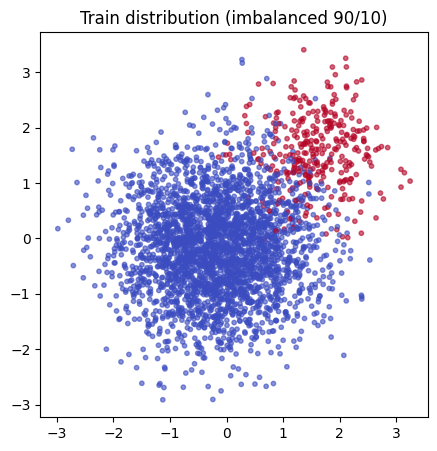

In [3]:
# Quick visual sanity check
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), s=10, cmap='coolwarm', alpha=0.6)
plt.title("Train distribution (imbalanced 90/10)")
plt.show()

### 5.2 Entraînement des modèles

On entraîne le modèle downstream de classification sur les données d'entraînement, puis on calcule le cache d'influence $G$ sur l'ensemble de validation.

In [4]:
# --- Models ---
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class SimpleDiffusionNet(nn.Module):
    def __init__(self, t_dim=16):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(2 + t_dim + 1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.float())
        y_emb = y.view(-1, 1).float()
        x_in = torch.cat([x, t_emb, y_emb], dim=1)
        return self.net(x_in)


class DDPMScheduler:
    def __init__(self, num_timesteps=50, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t].view(-1, 1)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t].view(-1, 1)
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,)).to(self.device)


In [5]:
# --- Training utils ---
@dataclass
class TrainConfig:
    clf_epochs: int = 80
    diff_epochs: int = 200
    clf_lr: float = 1e-3
    diff_lr: float = 1e-3
    timesteps: int = 50


def train_classifier(model, loader, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.clf_lr)
    crit = nn.CrossEntropyLoss()
    for _ in range(cfg.clf_epochs):
        for x, y in loader:
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()


def train_diffusion(model, loader, scheduler: DDPMScheduler, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.diff_lr)
    crit = nn.MSELoss()
    for _ in range(cfg.diff_epochs):
        for x, y in loader:
            opt.zero_grad()
            t = scheduler.sample_timesteps(x.shape[0]).view(-1, 1)
            x_t, noise = scheduler.noise_images(x, t)
            noise_pred = model(x_t, t, y)
            loss = crit(noise_pred, noise)
            loss.backward()
            opt.step()


def eval_classifier(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
    acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
    auroc = roc_auc_score(y.cpu().numpy(), probs.cpu().numpy())
    auprc = average_precision_score(y.cpu().numpy(), probs.cpu().numpy())
    return dict(acc=acc, auroc=auroc, auprc=auprc)


cfg_train = TrainConfig()
scheduler = DDPMScheduler(num_timesteps=cfg_train.timesteps, device=DEVICE)

## 5. Pipeline TarDiff avec données équilibrées (50/50)

Dans cette section, on entraîne un DDPM sur un dataset **équilibré**, puis on évalue :
- la fidélité distributionnelle (sanity checks),
- l'impact de la force de guidage $w$,
- l'impact downstream (TSTR).

L'objectif est d'établir une **baseline propre** avant de traiter le cas déséquilibré.

In [6]:
# --- Shared utilities for balanced/imbalanced experiments ---
from scipy.stats import wasserstein_distance

def sample_standard(model, scheduler, n_samples, c):
    """Génération standard sans guidage (w=0) pour validation."""
    model.eval()
    with torch.no_grad():
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y = torch.full((n_samples,), c, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            noise_pred = model(x, t, y)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred) + torch.sqrt(beta) * noise
    return x


def check_distribution_metrics(real_samples, fake_samples, name=""):
    print(f"--- Check Distribution: {name} ---")
    
    mu_dist = torch.norm(real_samples.mean(dim=0) - fake_samples.mean(dim=0)).item()
    std_dist = torch.norm(real_samples.std(dim=0) - fake_samples.std(dim=0)).item()
    print(f"Diff Mean (L2): {mu_dist:.4f}")
    print(f"Diff Std  (L2): {std_dist:.4f}")
    
    wd0 = wasserstein_distance(real_samples[:,0].cpu().numpy(), fake_samples[:,0].cpu().numpy())
    wd1 = wasserstein_distance(real_samples[:,1].cpu().numpy(), fake_samples[:,1].cpu().numpy())
    print(f"Wasserstein Dist | Dim0: {wd0:.4f}, Dim1: {wd1:.4f}")
    
    return mu_dist, std_dist, wd0, wd1


def compute_influence_cache(classifier, loader):
    classifier.eval()
    crit = nn.CrossEntropyLoss(reduction="sum")
    G = {name: torch.zeros_like(p) for name, p in classifier.named_parameters()}
    total = 0
    for x_g, y_g in loader:
        x_g, y_g = x_g.to(DEVICE), y_g.to(DEVICE)
        logits = classifier(x_g)
        loss = crit(logits, y_g)
        grads = torch.autograd.grad(loss, classifier.parameters())
        for (name, _), g in zip(classifier.named_parameters(), grads):
            G[name] += g
        total += x_g.shape[0]
    for name in G:
        G[name] /= max(1, total)
    return G


def tardiff_sample(model, scheduler, classifier, G_cache, n_samples=200, target_class=1, w=10.0):
    model.eval()
    classifier.eval()
    crit_clf = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y_cond = torch.full((n_samples,), target_class, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            predicted_noise = model(x, t, y_cond)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x_recon = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise)
            
            J = torch.zeros_like(x)
            if w != 0:
                with torch.enable_grad():
                    x_in = x.detach().clone()
                    x_in.requires_grad = True
                    
                    out_clf = classifier(x_in)
                    loss = crit_clf(out_clf, y_cond)
                    
                    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True)
                    
                    influence_score = 0
                    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
                        if name in G_cache:
                            influence_score += torch.sum(g_phi * G_cache[name])
                    
                    if isinstance(influence_score, torch.Tensor):
                        J = torch.autograd.grad(influence_score, x_in)[0]
                
                J = J.detach()
            
            sigma_t = torch.sqrt(beta)
            x = x_recon + (w * J) + sigma_t * noise
            
    return x.detach()


def plot_res_with_train(X_train_ref, samples, title, ax):
    ax.scatter(X_train_ref[:, 0].cpu(), X_train_ref[:, 1].cpu(), c='gray', s=5, alpha=0.1, label='Real Train')
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), c='red', s=15, alpha=0.6, label='Generated (Class 1)')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)


def tstr_evaluation_generic(X_train_ref, y_train_ref, X_test_ref, y_test_ref, syn_min_samples, name="", epochs=30):
    mask_0 = (y_train_ref == 0)
    X_maj_real = X_train_ref[mask_0]
    y_maj_real = y_train_ref[mask_0]
    
    X_syn_1 = syn_min_samples
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)
    
    X_train_mix = torch.cat([X_maj_real, X_syn_1])
    y_train_mix = torch.cat([y_maj_real, y_syn_1])
    
    loader_mix = DataLoader(TensorDataset(X_train_mix, y_train_mix), batch_size=64, shuffle=True)
    
    new_clf = SimpleClassifier().to(DEVICE)
    train_classifier(new_clf, loader_mix, TrainConfig(clf_epochs=epochs))
    
    res = eval_classifier(new_clf, X_test_ref, y_test_ref)
    print(f"[{name}] TSTR Results: {res}")
    return res


def build_guide_loaders(X_guide, y_guide, batch_size=None):
    if batch_size is None:
        batch_size = len(X_guide)
    loader_all = DataLoader(TensorDataset(X_guide, y_guide), batch_size=batch_size, shuffle=False)
    mask_maj = (y_guide == 0)
    mask_min = (y_guide == 1)
    loader_maj = DataLoader(TensorDataset(X_guide[mask_maj], y_guide[mask_maj]), batch_size=max(1, len(X_guide[mask_maj])), shuffle=False)
    loader_min = DataLoader(TensorDataset(X_guide[mask_min], y_guide[mask_min]), batch_size=max(1, len(X_guide[mask_min])), shuffle=False)
    return loader_all, loader_maj, loader_min


def guidance_sweep(model, scheduler, classifier, G_cache, w_values, n_samples, target_class):
    samples_by_w = {}
    for w in w_values:
        samples_by_w[w] = tardiff_sample(model, scheduler, classifier, G_cache, n_samples=n_samples, target_class=target_class, w=w)
    return samples_by_w

Balanced Train size: torch.Size([3200, 2]) Guide size: torch.Size([800, 2])
Balanced Test size: torch.Size([2000, 2])


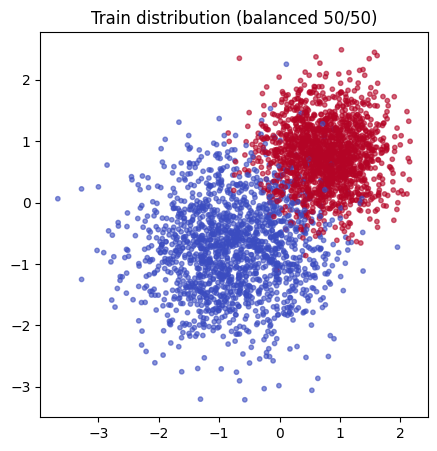

In [7]:
# --- Balanced Dataset (50/50) ---
cfg_bal = ToyConfig(minority_ratio=0.5)
train_loader_bal, guide_loader_bal, (X_train_bal, y_train_bal), (X_test_bal, y_test_bal), stats_bal = make_toy_gaussians(cfg_bal)
print("Balanced Train size:", X_train_bal.shape, "Guide size:", next(iter(guide_loader_bal))[0].shape)
print("Balanced Test size:", X_test_bal.shape)

plt.figure(figsize=(5, 5))
plt.scatter(X_train_bal[:, 0].cpu(), X_train_bal[:, 1].cpu(), c=y_train_bal.cpu(), s=10, cmap='coolwarm', alpha=0.6)
plt.title("Train distribution (balanced 50/50)")
plt.show()

In [8]:
# --- Training (Balanced 50/50) ---
cfg_train_bal = TrainConfig()
scheduler_bal = DDPMScheduler(num_timesteps=cfg_train_bal.timesteps, device=DEVICE)

clf_bal = SimpleClassifier().to(DEVICE)
train_classifier(clf_bal, train_loader_bal, cfg_train_bal)
metrics_real_bal = eval_classifier(clf_bal, X_test_bal, y_test_bal)
print("Downstream on real (balanced):", metrics_real_bal)

G_cache_bal = compute_influence_cache(clf_bal, guide_loader_bal)
print("Influence cache norms (balanced):", {k: float(v.norm().item()) for k, v in G_cache_bal.items()})

diff_model_bal = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model_bal, train_loader_bal, scheduler_bal, cfg_train_bal)
print("Diffusion trained (balanced).")

Downstream on real (balanced): {'acc': 0.9945, 'auroc': 1.0, 'auprc': 1.0}
Influence cache norms (balanced): {'net.0.weight': 0.013574592769145966, 'net.0.bias': 0.022460145875811577, 'net.2.weight': 0.04470484331250191, 'net.2.bias': 0.01722222939133644, 'net.4.weight': 0.06358225643634796, 'net.4.bias': 0.01905255764722824}
Diffusion trained (balanced).


Generating validation samples (balanced)...
--- Check Distribution: Balanced Class 0 ---
Diff Mean (L2): 0.5906
Diff Std  (L2): 0.1195
Wasserstein Dist | Dim0: 0.4373, Dim1: 0.3970
--- Check Distribution: Balanced Class 1 ---
Diff Mean (L2): 0.3337
Diff Std  (L2): 0.1511
Wasserstein Dist | Dim0: 0.2461, Dim1: 0.2271


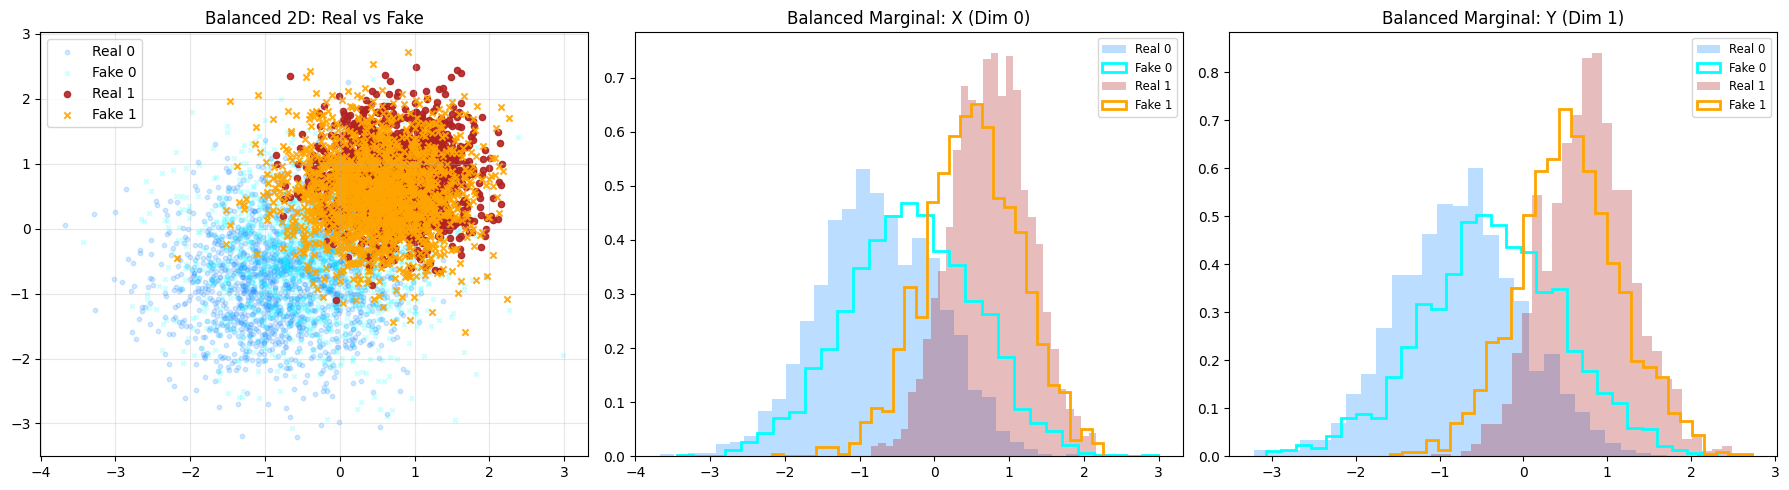

In [9]:
# --- Sanity Checks (Balanced 50/50) ---
print("Generating validation samples (balanced)...")

X_maj_real_bal = X_train_bal[y_train_bal == 0]
X_maj_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_maj_real_bal), 0)

X_min_real_bal = X_train_bal[y_train_bal == 1]
X_min_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_min_real_bal), 1)

check_distribution_metrics(X_maj_real_bal, X_maj_gen_bal, "Balanced Class 0")
check_distribution_metrics(X_min_real_bal, X_min_gen_bal, "Balanced Class 1")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Balanced 2D: Real vs Fake")
axes[0].scatter(X_maj_real_bal[:,0].cpu(), X_maj_real_bal[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen_bal[:,0].cpu(), X_maj_gen_bal[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real_bal[:,0].cpu(), X_min_real_bal[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen_bal[:,0].cpu(), X_min_gen_bal[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Balanced Marginal: {name}")
    ax.hist(X_maj_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    ax.hist(X_maj_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    ax.hist(X_min_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    ax.hist(X_min_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

Sampling 500 points per w (balanced)...


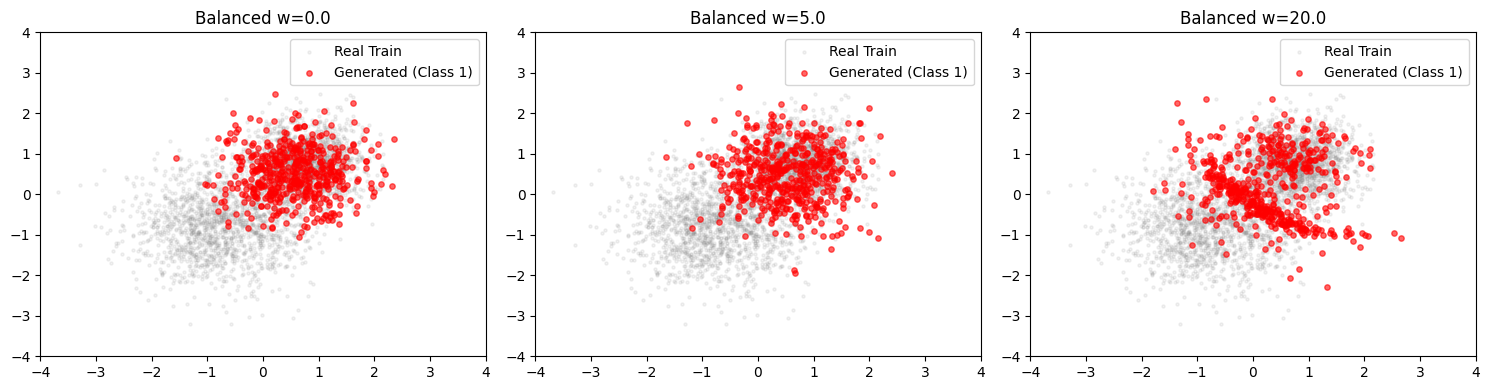

In [10]:
# --- Guidance Sweep (Balanced 50/50) ---
N_GEN_BAL = 500
w_values_bal = [0.0, 5.0, 20.0]
print(f"Sampling {N_GEN_BAL} points per w (balanced)...")

samples_bal = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf_bal,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=1
)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train_bal, samples_bal[w], f"Balanced w={w}", ax)
plt.tight_layout()
plt.show()

In [11]:
# --- Downstream Utility (Balanced 50/50) ---
print("\n--- Downstream Utility (Balanced 50/50) ---")
results_bal = {}
for w, samples in samples_bal.items():
    results_bal[w] = tstr_evaluation_generic(
        X_train_bal, y_train_bal, X_test_bal, y_test_bal,
        samples,
        name=f"Balanced w={w}",
        epochs=30
    )
print("Summary (Balanced):", results_bal)


--- Downstream Utility (Balanced 50/50) ---
[Balanced w=0.0] TSTR Results: {'acc': 0.993, 'auroc': 1.0, 'auprc': 1.0}
[Balanced w=5.0] TSTR Results: {'acc': 0.996, 'auroc': 1.0, 'auprc': 1.0}
[Balanced w=20.0] TSTR Results: {'acc': 0.997, 'auroc': 1.0, 'auprc': 1.0}
Summary (Balanced): {0.0: {'acc': 0.993, 'auroc': 1.0, 'auprc': 1.0}, 5.0: {'acc': 0.996, 'auroc': 1.0, 'auprc': 1.0}, 20.0: {'acc': 0.997, 'auroc': 1.0, 'auprc': 1.0}}


## 6. Cas déséquilibré (90/10)

On répète le pipeline sur un dataset **déséquilibré** pour analyser :
- l'impact de $w$ (guidance strength),
- l'impact downstream (TSTR),
- le choix du guidance set (tous / majorité / minorité).

### 6.1 Entraîner le classifieur downstream

In [12]:
# --- Train downstream classifier ---
clf = SimpleClassifier().to(DEVICE)
train_classifier(clf, train_loader, cfg_train)
metrics_real = eval_classifier(clf, X_test, y_test)
print("Downstream on real:", metrics_real)

Downstream on real: {'acc': 0.981, 'auroc': 1.0, 'auprc': 1.0}


Maintenant, calculons le cache d'influence $G$ sur l'ensemble de validation :

In [13]:
# --- Influence cache ---
G_cache = compute_influence_cache(clf, guide_loader)
print("Influence cache norms:", {k: float(v.norm().item()) for k, v in G_cache.items()})

Influence cache norms: {'net.0.weight': 0.023729810491204262, 'net.0.bias': 0.015771329402923584, 'net.2.weight': 0.03829487785696983, 'net.2.bias': 0.007750583812594414, 'net.4.weight': 0.04348886013031006, 'net.4.bias': 0.00848672166466713}


In [14]:
# --- Guidance set variants (imbalanced) ---
X_guide_all, y_guide_all = next(iter(guide_loader))

guide_all_loader, guide_maj_loader, guide_min_loader = build_guide_loaders(X_guide_all, y_guide_all)

G_cache_all = G_cache
G_cache_maj = compute_influence_cache(clf, guide_maj_loader)
G_cache_min = compute_influence_cache(clf, guide_min_loader)

print("Influence cache norms (all):", {k: float(v.norm().item()) for k, v in G_cache_all.items()})
print("Influence cache norms (major):", {k: float(v.norm().item()) for k, v in G_cache_maj.items()})
print("Influence cache norms (minor):", {k: float(v.norm().item()) for k, v in G_cache_min.items()})

Influence cache norms (all): {'net.0.weight': 0.023729810491204262, 'net.0.bias': 0.015771329402923584, 'net.2.weight': 0.03829487785696983, 'net.2.bias': 0.007750583812594414, 'net.4.weight': 0.04348886013031006, 'net.4.bias': 0.00848672166466713}
Influence cache norms (major): {'net.0.weight': 0.11521143466234207, 'net.0.bias': 0.0715542808175087, 'net.2.weight': 0.17588111758232117, 'net.2.bias': 0.03750748187303543, 'net.4.weight': 0.1903354972600937, 'net.4.bias': 0.038529183715581894}
Influence cache norms (minor): {'net.0.weight': 0.8943935632705688, 'net.0.bias': 0.5092263221740723, 'net.2.weight': 1.2387045621871948, 'net.2.bias': 0.2567996680736542, 'net.4.weight': 1.2742851972579956, 'net.4.bias': 0.2581864595413208}


#### 6.1.1 Variantes de guidance set (All / Majority / Minority)

On isole le guidance set selon la classe pour analyser comment le cache d'influence $G$ change et comment cela affecte la génération.

Enfin, entraînons le modèle de diffusion :

In [15]:
# --- Diffusion training ---
diff_model = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model, train_loader, scheduler, cfg_train)
print("Diffusion trained.")

Diffusion trained.


### 6.2 Sanity check: Fidélité distributionnelle (w=0)

Avant d'appliquer TarDiff, il est crucial de vérifier que notre modèle DDPM de base (sans guidage, $w=0$) a bien appris la distribution conditionnelle $p(x|y)$.
Nous comparons ici les données réelles et les données générées via :
1.  **Marginales** : Histogrammes par dimension.
2.  **Moments** : Moyenne et écart-type par classe.
3.  **Scatter plot complet** : Visualisation globale des deux classes.

Generating validation samples...
--- Check Distribution: Class 0 (Majoritaire) ---
Diff Mean (L2): 0.1653
Diff Std  (L2): 0.0378
Wasserstein Dist | Dim0: 0.0473, Dim1: 0.1624
--- Check Distribution: Class 1 (Minoritaire) ---
Diff Mean (L2): 0.9108
Diff Std  (L2): 0.1054
Wasserstein Dist | Dim0: 0.7313, Dim1: 0.5429


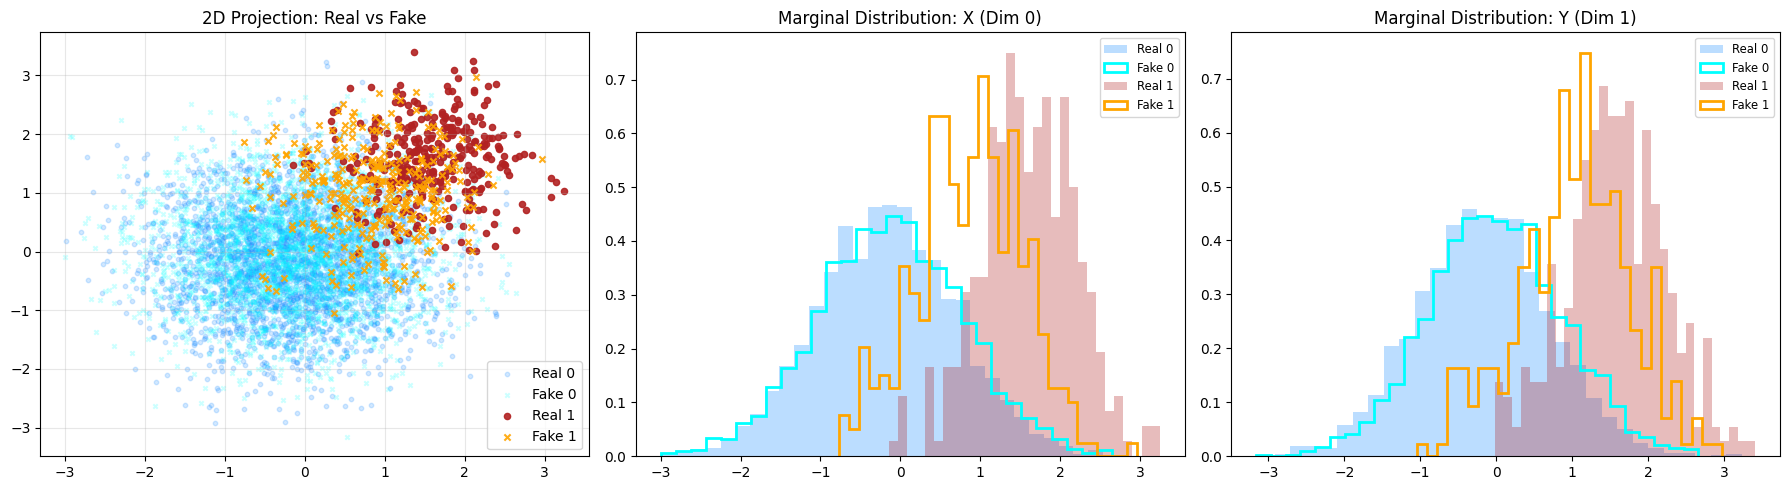

In [16]:
# --- Run Validation & Plots ---

print("Generating validation samples...")
# On valide séparément les deux classes pour voir si le conditionnement marche
X_maj_real = X_train[y_train==0]
X_maj_gen = sample_standard(diff_model, scheduler, len(X_maj_real), 0)

X_min_real = X_train[y_train==1]
X_min_gen = sample_standard(diff_model, scheduler, len(X_min_real), 1)

# Metrics
check_distribution_metrics(X_maj_real, X_maj_gen, "Class 0 (Majoritaire)")
check_distribution_metrics(X_min_real, X_min_gen, "Class 1 (Minoritaire)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter Plot Overlay
axes[0].set_title("2D Projection: Real vs Fake")
axes[0].scatter(X_maj_real[:,0].cpu(), X_maj_real[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen[:,0].cpu(), X_maj_gen[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real[:,0].cpu(), X_min_real[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen[:,0].cpu(), X_min_gen[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distributions Marginales
for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Marginal Distribution: {name}")
    # Real 0
    ax.hist(X_maj_real[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    # Fake 0
    ax.hist(X_maj_gen[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    # Real 1
    ax.hist(X_min_real[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    # Fake 1
    ax.hist(X_min_gen[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

On voit que la classe majoritaire est bien capturée, tandis que la classe minoritaire est bien moins synthétisée, ce qui est attendu vu son faible effectif dans les données d'entraînement. En effet, la loss de diffusion est dominée par la classe majoritaire, ce qui conduit le modèle à privilégier cette région de l'espace.

### 6.3 Résultats principaux : TarDiff Sampling

- On génère des samples pour la classe minoritaire ($y=1$)
- **Baseline** : diffusion standard ($w=0$).
- **TarDiff** : diffusion guidée avec influence ($w=10$ ou plus).
- On visualise les points générés par rapport à la distribution réelle et à la frontière de décision.

In [17]:
# --- Génération (imbalanced 90/10) ---
N_GEN = 500
w_values = [0.0, 10.0, 30.0]
print(f"Sampling {N_GEN} points per w (imbalanced)...")

samples_by_w = guidance_sweep(
    diff_model,
    scheduler,
    clf,
    G_cache_all,
    w_values=w_values,
    n_samples=N_GEN,
    target_class=1
)

w_choice = 10.0
samples_by_guidance = {
    "All": tardiff_sample(diff_model, scheduler, clf, G_cache_all, n_samples=N_GEN, target_class=1, w=w_choice),
    "Majority": tardiff_sample(diff_model, scheduler, clf, G_cache_maj, n_samples=N_GEN, target_class=1, w=w_choice),
    "Minority": tardiff_sample(diff_model, scheduler, clf, G_cache_min, n_samples=N_GEN, target_class=1, w=w_choice)
}

print("Sampling done (imbalanced).")

Sampling 500 points per w (imbalanced)...
Sampling done (imbalanced).
Sampling done (imbalanced).


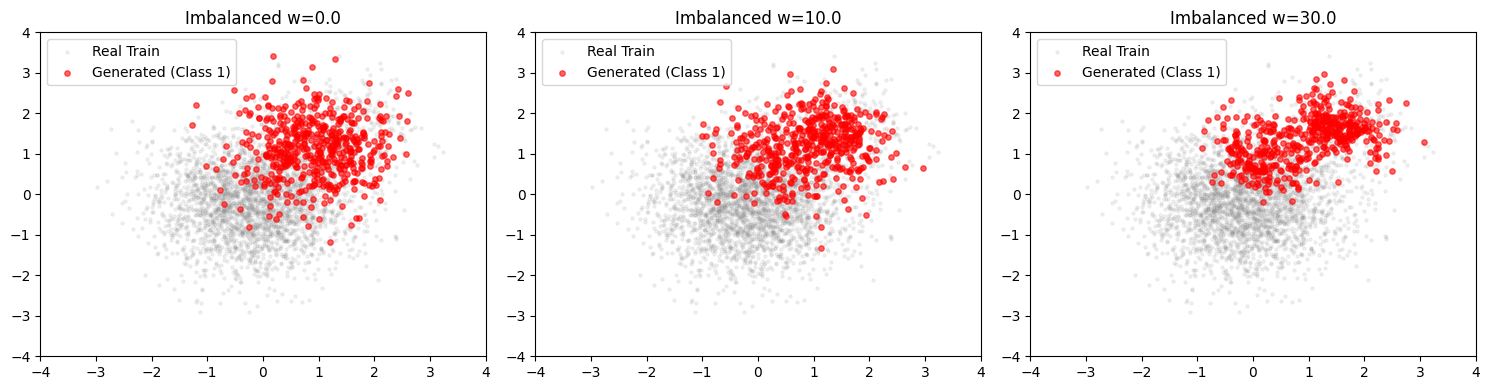

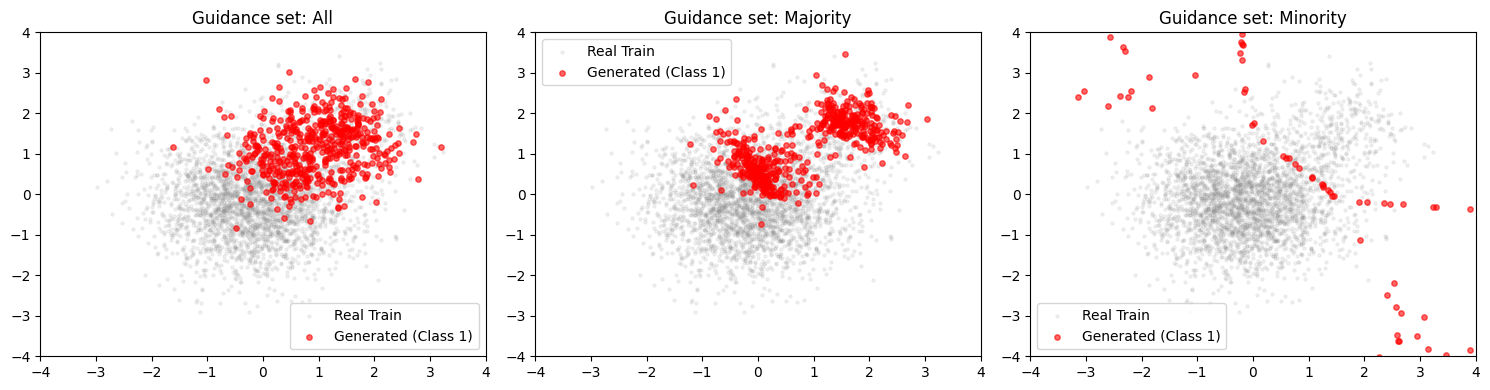

In [18]:
# --- Visualization (imbalanced) ---
fig, axes = plt.subplots(1, len(w_values), figsize=(5 * len(w_values), 4))
if len(w_values) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values):
    plot_res_with_train(X_train, samples_by_w[w], f"Imbalanced w={w}", ax)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, samples) in zip(axes, samples_by_guidance.items()):
    plot_res_with_train(X_train, samples, f"Guidance set: {name}", ax)
plt.tight_layout()
plt.show()

Computing per-sample gradient norms on Guide Set...
Mean Norm Major (Class 0): 0.3334 +/- 1.5180
Mean Norm Minor (Class 1): 2.2490 +/- 2.4497
Mean Norm Major (Class 0): 0.3334 +/- 1.5180
Mean Norm Minor (Class 1): 2.2490 +/- 2.4497


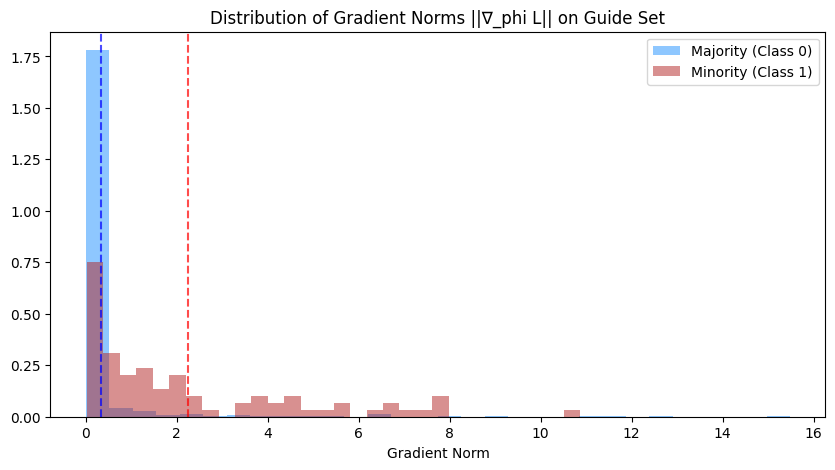

In [19]:
# --- Gradient Norm Analysis ---

def analyze_gradient_norms(classifier, loader):
    classifier.eval()
    criterion = nn.CrossEntropyLoss()
    
    norms_maj = []
    norms_min = []
    
    print("Computing per-sample gradient norms on Guide Set...")
    
    # On récupère toutes les données
    all_X, all_y = [], []
    for x, y in loader:
        all_X.append(x)
        all_y.append(y)
    
    if not all_X: return [], []
    
    X_all = torch.cat(all_X)
    y_all = torch.cat(all_y)
    
    # Boucle sample par sample
    with torch.set_grad_enabled(True):
        for i in range(len(X_all)):
            x_i = X_all[i:i+1].to(DEVICE)
            y_i = y_all[i:i+1].to(DEVICE)
            
            output = classifier(x_i)
            loss = criterion(output, y_i)
            
            grads = torch.autograd.grad(loss, classifier.parameters())
            
            # Norme L2 concaténée
            total_norm_sq = 0.0
            for g in grads:
                total_norm_sq += g.norm(2).item() ** 2
            total_norm = math.sqrt(total_norm_sq)
            
            if y_i.item() == 0:
                norms_maj.append(total_norm)
            else:
                norms_min.append(total_norm)
                
    return np.array(norms_maj), np.array(norms_min)

norms_maj, norms_min = analyze_gradient_norms(clf, guide_loader)

print(f"Mean Norm Major (Class 0): {norms_maj.mean():.4f} +/- {norms_maj.std():.4f}")
print(f"Mean Norm Minor (Class 1): {norms_min.mean():.4f} +/- {norms_min.std():.4f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.hist(norms_maj, bins=30, alpha=0.5, label=f'Majority (Class 0)', density=True, color='dodgerblue')
plt.hist(norms_min, bins=30, alpha=0.5, label=f'Minority (Class 1)', density=True, color='firebrick')
plt.axvline(norms_maj.mean(), color='blue', linestyle='--', alpha=0.7)
plt.axvline(norms_min.mean(), color='red', linestyle='--', alpha=0.7)
plt.title("Distribution of Gradient Norms ||∇_phi L|| on Guide Set")
plt.xlabel("Gradient Norm")
plt.legend()
plt.show()

### 6.4 Utilité Downstream (Train on Synthetic, Test on Real)

On entraîne un **nouveau classifieur** uniquement sur les données synthétiques générées (augmentées ou remplacées) et on teste sur le vrai test set.
Ici, on remplace la classe minoritaire par des données synthétiques.

- **Expérience** : Class 0 (Réel) + Class 1 (Synthétique).
- **Comparaison** : impact de $w$ et du guidance set (all/major/minor).

In [20]:
print("\n--- Downstream Utility Evaluation (Imbalanced 90/10) ---")

results_w_imb = {}
for w, samples in samples_by_w.items():
    results_w_imb[w] = tstr_evaluation_generic(
        X_train, y_train, X_test, y_test,
        samples,
        name=f"Imbalanced w={w}",
        epochs=30
    )

results_guidance_imb = {}
for name, samples in samples_by_guidance.items():
    results_guidance_imb[name] = tstr_evaluation_generic(
        X_train, y_train, X_test, y_test,
        samples,
        name=f"Imbalanced guidance={name}",
        epochs=30
    )

print("Summary (Imbalanced - w sweep):", results_w_imb)
print("Summary (Imbalanced - guidance):", results_guidance_imb)


--- Downstream Utility Evaluation (Imbalanced 90/10) ---
[Imbalanced w=0.0] TSTR Results: {'acc': 0.995, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=0.0] TSTR Results: {'acc': 0.995, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=10.0] TSTR Results: {'acc': 0.9855, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=10.0] TSTR Results: {'acc': 0.9855, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=30.0] TSTR Results: {'acc': 0.9665, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=30.0] TSTR Results: {'acc': 0.9665, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced guidance=All] TSTR Results: {'acc': 0.9895, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced guidance=All] TSTR Results: {'acc': 0.9895, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced guidance=Majority] TSTR Results: {'acc': 0.938, 'auroc': 0.999996, 'auprc': 0.9999960089730808}
[Imbalanced guidance=Majority] TSTR Results: {'acc': 0.938, 'auroc': 0.999996, 'auprc': 0.9999960089730808}
[Imbalanced guidance=Minority] TSTR Results: {'acc': 0.5015, 'auroc': 0.9933569999999999, 'aup

## 7. Discussion et Conclusion

### Discussion

1. **Balanced (50/50)** : Le DDPM capture bien la distribution et la guidance $w$ montre un compromis clair entre diversité et utilité downstream.
2. **Imbalanced (90/10)** : La diffusion standard favorise la classe majoritaire. TarDiff aide la minorité, mais un $w$ trop fort entraîne du collapse.
3. **Choix du guidance set** : Un guidance set centré sur la minorité augmente l'impact des gradients de classe rare, mais peut accentuer le sur-guidage. Un guidance set mixte reste le plus stable.

### Conclusion

Nous avons implémenté **TarDiff** sur un problème jouet complet.
- **Formulation** : Guidage orienté par un gradient d'influence.
- **Code** : Pipeline complet PyTorch (Data, Model, Diff, Influence, Sampling).
- **Résultats** : Confirmation que le guidage par influence permet de manipuler la génération pour favoriser une tâche cible, au-delà de la simple fidélité.

**Next steps possibles** :
- Appliquer sur des séries temporelles réelles (EHR) avec un backbone (i.e. Transformer/RNN).
- Explorer des métriques de diversité pour quantifier formellement le trade-off.
- Tester sur un cas où le shift distributionnel (train vs test) est plus marqué.